In [1]:
import joblib
import pandas as pd
import seaborn as sb
import glob
import matplotlib.pyplot as plt
import truvari
from sklearn.metrics import roc_curve, roc_auc_score
sb.set()

In [2]:
parts = []
for i in glob.glob("../data/ss_discovery/*/*/*/truvari/data.jl"):
    d = joblib.load(i)
    i = i.split('/')
    d["sample"] = i[-3]
    d["reference"] = i[-4]
    d["program"] = i[-5]
    parts.append(d)
data = pd.concat(parts)
#data = data[~(data["sample"] == "NA18939")]
idx = data[(data["qual"] == 0) & (data["state"].isin(["tp", "fp"]))].index
data = data.drop(index=idx)
# Remove manta's DUPs, they shouldn't be penalized for them
idx = data[(data["svtype"] == "DUP")].index
data = data.drop(index=idx)

In [3]:
metadata = pd.read_csv("../lra_sr_metadata.txt", sep="\t")
metadata = metadata.set_index("Individual")

In [4]:
def acc(grp):
    view = grp["state"].value_counts()
    fp = view["fp"] if "fp" in view else 0
    tp = view["tp"] if "tp" in view else 0
    fn = view["fn"] if "fn" in view else 0
    tpbase = view["tpbase"] if "tpbase" in view else 0
    if tp + fp != 0:
        precision = tp / (tp + fp)
    else:
        precision = 0
    if tpbase + fn != 0:
        recall = tpbase / (tpbase + fn)
    else:
        recall = 0
    neum = recall * precision
    denom = recall + precision
    if denom != 0:
        f1 = 2 * (neum / denom)
    else:
        f1 = None
    return precision, recall, f1

summary = []
for samp, dat in data.groupby(["sample", "reference", "program"]):
    summary.append([*samp, metadata.loc[samp[0]]["Superpopulation code"], *acc(dat)])
summary = pd.DataFrame(summary, columns=["Sample", "Reference", "Program", 
                                         "Superpopulation", "Precision", "Recall", "F1"])

In [5]:
grab = (summary["Program"] == "biograph") & (summary["F1"] > 0.550)
grab = grab | (summary["Program"] == "biograph") & (summary["Reference"] == "chm13") & (summary["F1"] > 0.52)
grab = grab | (summary["Program"] == "manta") & (summary["F1"] > 0.475)
grab = grab | (summary["Precision"] < 0.750)
grab = grab | ((summary["Program"] == "biograph") & (summary["Precision"] > 0.831) & (summary["Reference"] == "hg19"))
summary[grab]

,Sample,Reference,Program,Superpopulation,Precision,Recall,F1
12,HG00513,chm13,biograph,EAS,0.786743,0.392351,0.523588
13,HG00513,grch38,biograph,EAS,0.800072,0.444291,0.571320
14,HG00513,grch38,manta,EAS,0.866687,0.337403,0.485716
15,HG00513,hg19,biograph,EAS,0.797037,0.441221,0.568007
83,HG03486,hg19,biograph,AFR,0.838747,0.372058,0.515463
101,NA18939,grch38,biograph,EAS,0.661733,0.397657,0.496782
102,NA18939,grch38,manta,EAS,0.707268,0.292900,0.414248
123,NA19983,hg19,biograph,AFR,0.835990,0.354076,0.497458


In [6]:
# Just remove the EAS samples
grab = summary["Sample"].isin(["HG00513", "NA18939"])

In [7]:
metadata.loc[["HG00513", "NA18939"]]

,FamilyId,TrioState,Sex,Population code,Population name,Superpopulation code,Superpopulation name,AltIDs
Individual,,,,,,,,
HG00513,SH032,mother,female,CHS,Southern Han Chinese,EAS,East Asian Ancestry,NaN
NA18939,NA18939,unrel,female,JPT,Japanese,EAS,East Asian Ancestry,NaN


# Performance Summary

In [25]:
summary.groupby(["Program"]).mean().applymap('{:.3f}'.format).T

Program,biograph,manta
Precision,0.818,0.884
Recall,0.386,0.312
F1,0.514,0.448


In [24]:
summary.groupby(["Program", "Reference"]).mean().applymap('{:.3f}'.format).T

Program   biograph                manta
Reference    chm13 grch38   hg19 grch38
Precision    0.814  0.819  0.821  0.884
Recall       0.345  0.409  0.406  0.312
F1           0.479  0.532  0.530  0.448

In [22]:
summary = []
for samp, dat in data.groupby(["sample", "svtype", "program", "reference"]):
    summary.append([samp[0], samp[2], samp[3], metadata.loc[samp[0]]["Superpopulation code"], samp[1], *acc(dat)])
summary = pd.DataFrame(summary, columns=["Sample", "Program", "Reference", "Superpopulation", "svtype", "Precision", "Recall", "F1"])

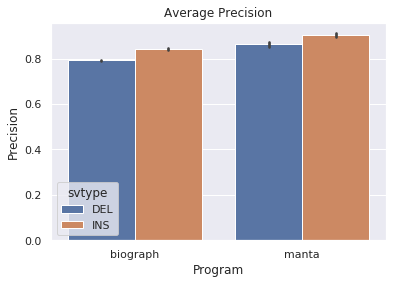

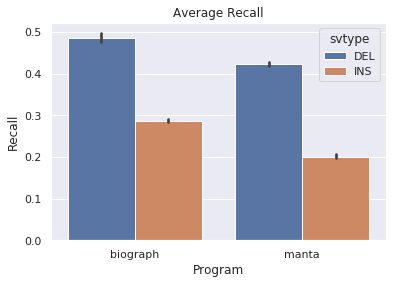

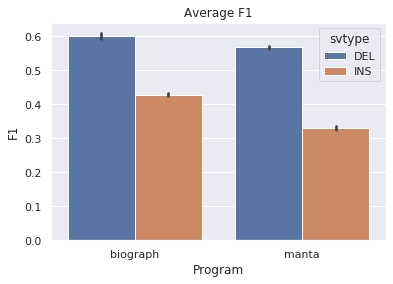

In [12]:
for i in ["Precision", "Recall", "F1"]:
    p = sb.barplot(data=summary, 
                   x="Program", 
                   y=i,
                  hue="svtype",
                  hue_order=["DEL", "INS"])
    p.set(title="Average " + i)
    plt.show()

# Performance by SZBIN/SVTYPE

In [26]:
summary = []
for samp, dat in data.groupby(["sample", "svtype", "szbin", "reference", "program"]):
    summary.append([samp[0], metadata.loc[samp[0]]["Superpopulation code"], samp[1], samp[2], samp[3], samp[4], *acc(dat)])
summary = pd.DataFrame(summary, columns=["Sample", "Superpopulation", "svtype", "szbin", "Reference", "Program", "Precision", "Recall", "F1"])
summary["szbin"] = summary["szbin"].astype(truvari.SZBINTYPE)

In [83]:
x = summary.groupby(["Program", "szbin", "svtype"]).mean()#.applymap('{:.3f}'.format)
(x.loc["biograph"] - x.loc["manta"]) \
    .style.apply(lambda x: ["color: teal" if v < 0 else "color: brown" for v in x], axis = 1) \
    .applymap('{:.3f}'.format)

In [49]:
def size_stat_summary(m_data, y_var):
    p = sb.catplot(data=m_data, 
                x="szbin", 
                y="Precision", 
                hue="svtype", 
                order=truvari.SZBINS[1:],
                kind="bar",
                col="Program")
    p.fig.subplots_adjust(top=0.8) 
    hide = p.fig.suptitle(f"Average {y_var} across samples by SVTYPE/Program")
    for axes in p.axes.flat:
        _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha="right")
    plt.show()

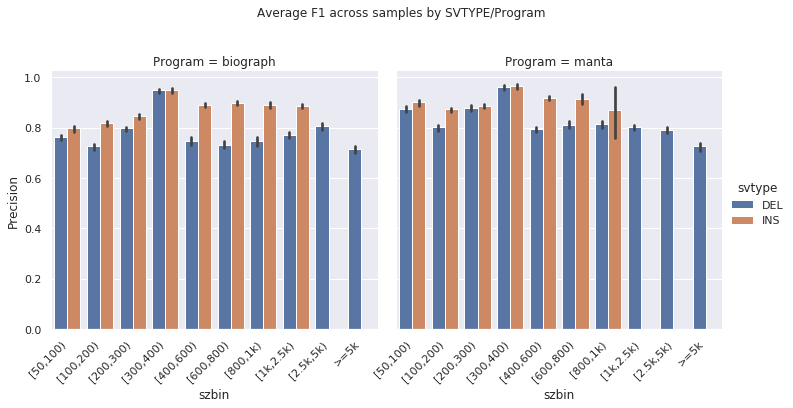

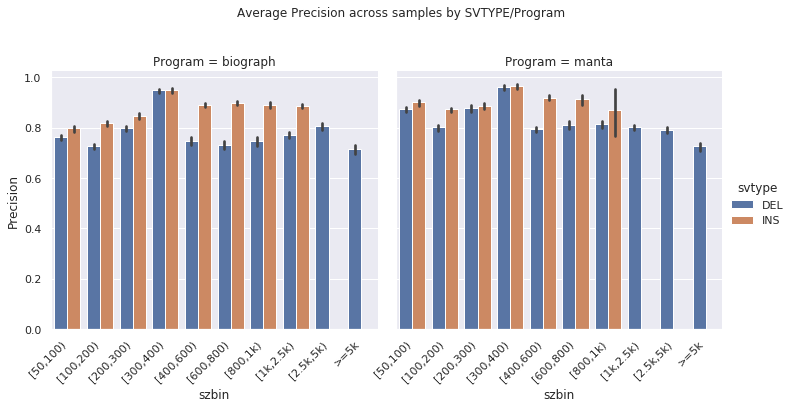

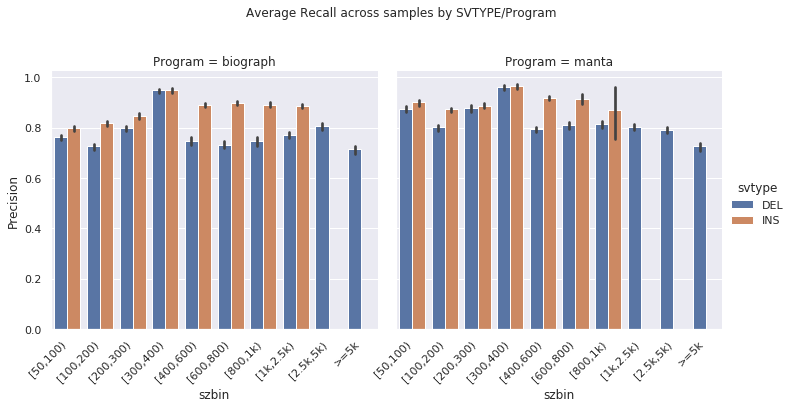

In [84]:
ref_grab = summary["Reference"] == "grch38"
size_stat_summary(summary[ref_grab], "F1")
size_stat_summary(summary[ref_grab], "Precision")
size_stat_summary(summary[ref_grab], "Recall")

# QUAL ROC 

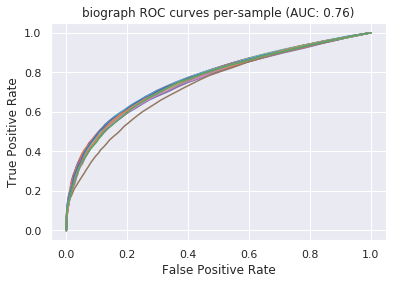

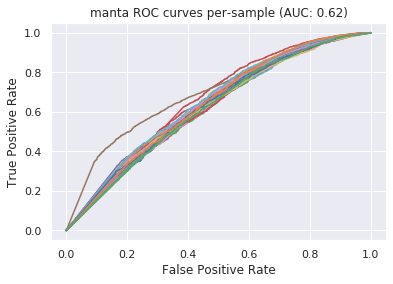

In [48]:
for prog, d1 in data.groupby("program"):
    m_auc = []
    for samp, dat in d1.groupby("sample"):
        view = dat[dat["state"].isin(["tp", "fp"])]
        #view.loc[view["state"] == "fn", "qual"] = -1
        fpr, tpr, thresholds = roc_curve(view["state"] == "tp", view["qual"])
        auc = roc_auc_score(view["state"] == "tp", view["qual"])
        plt.plot(fpr, tpr, label="%s (%.2f)" % (samp, auc))
        m_auc.append(auc)
    m_auc = pd.Series(auc).mean()
    plt.title(f"{prog} ROC curves per-sample (AUC: {m_auc:.2f})")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

# Extra

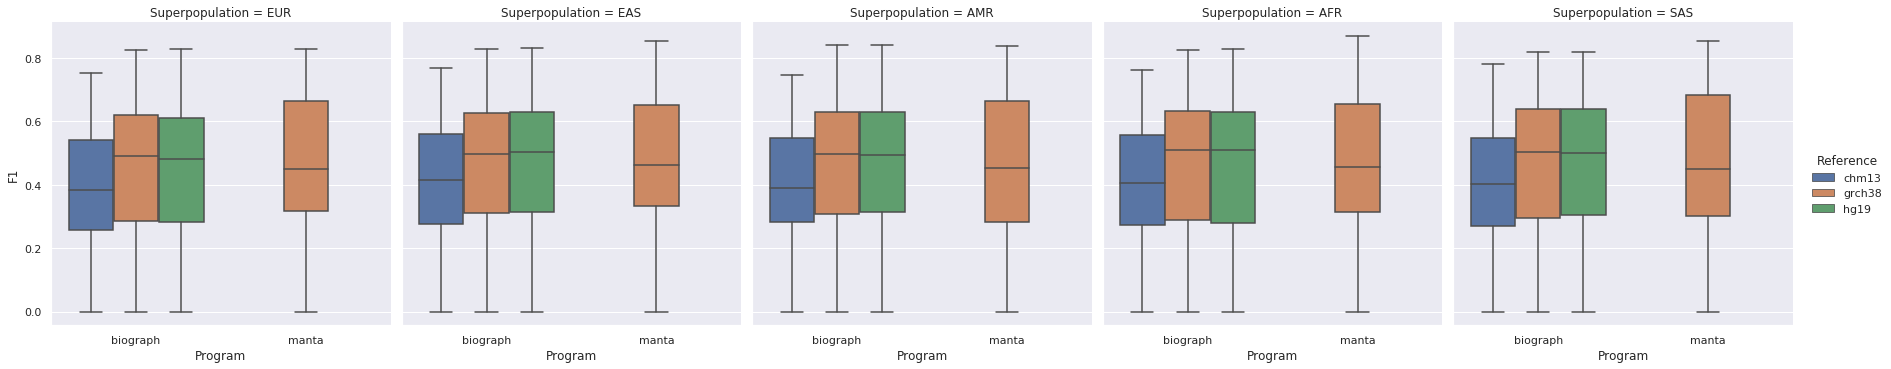

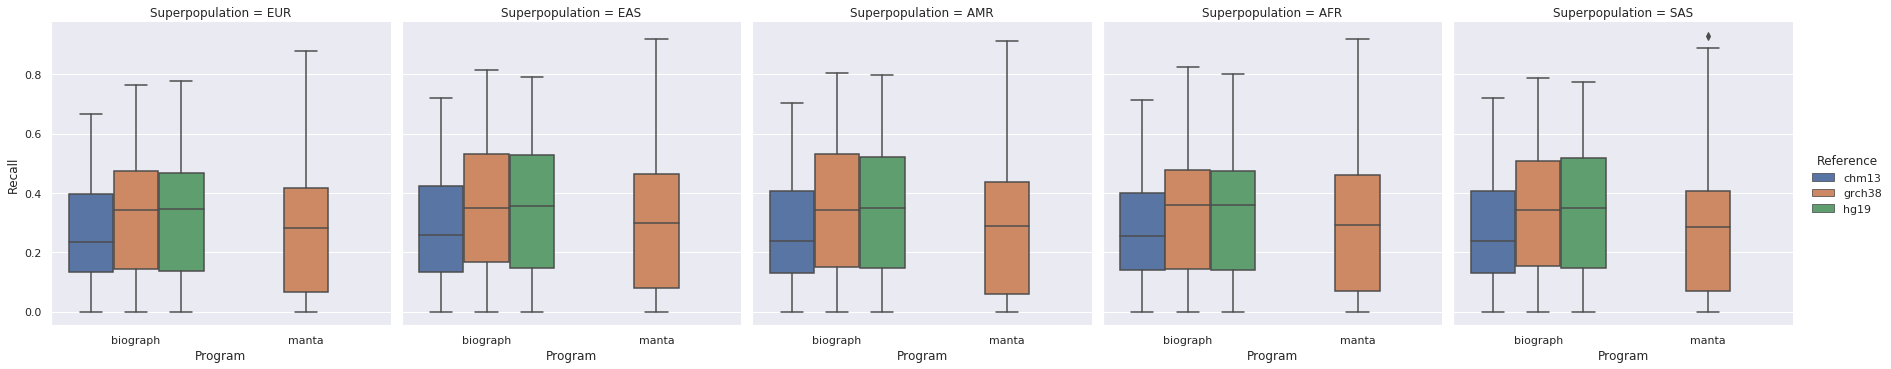

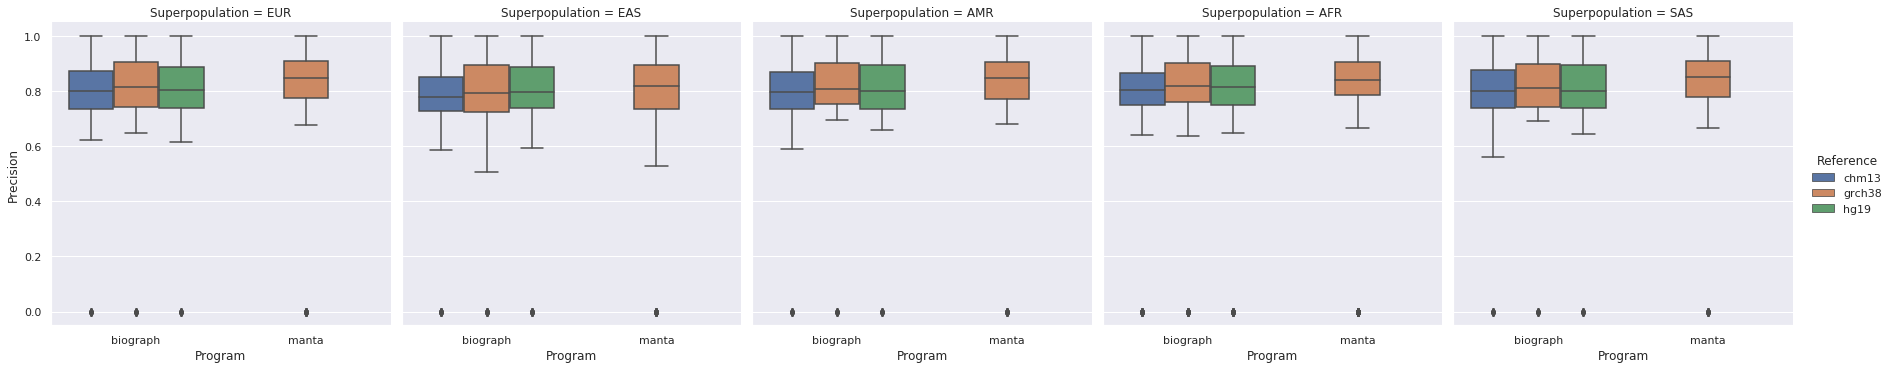

In [51]:
for y in ["F1", "Recall", "Precision"]:
    sb.catplot(data=summary,#[~grab], 
           x="Program", 
           y=y, 
           hue="Reference", 
           col="Superpopulation",
           kind="box")

In [85]:
s = pd.Series([0.3013107737577744,
 0.2859794788713379,
 0.2831705690865592,
 0.29108810049227635,
 0.2748468682078641,
 0.27638343931808956,
 0.2879510134480487,
 0.2929617720614505,
 0.267629533167594,
 0.2884837766138358,
 0.28915420485608617,
 0.2832516210659497,
 0.2790863668807994,
 0.2745111422038699,
 0.2884255000170364,
 0.27048003414955957,
 0.298952050409408,
 0.272737964560138,
 0.2780624310263282,
 0.2901273633415078,
 0.3373815980819872,
 0.2701071853910282,
 0.268208778173191,
 0.2839821314613912,
 0.2828497950654987,
 0.28877256035627785,

 0.2743823146944083,])

In [86]:
s.describe()

count    27.000000
mean      0.284455
std       0.013937
min       0.267630
25%       0.274679
50%       0.283252
75%       0.288963
max       0.337382
dtype: float64